In [ ]:
!pip install seaborn

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers, models, Model
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix


# --- KONFIGURASI GPU ---
# Kode ini mencegah GPU langsung memakan 100% VRAM saat inisialisasi
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

# Konfigurasi Seed agar hasil bisa direproduksi
print("Versi TF:", tf.__version__) # Harus 2.10.x
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)
print("Nama Device:", tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.random.set_seed(42)
np.random.seed(42)

Versi TF: 2.20.0
GPU Available: False
Nama Device: []
Num GPUs Available:  0


In [ ]:
# Path Dataset (Sesuaikan dengan folder lokal Anda)
# Dataset harus memiliki struktur:
# DATA_DIR/
#   train/
#     normal/
#     benign/
#     malignant/
#   validation/
#     normal/
#     benign/
#     malignant/
#   test/
#     normal/
#     benign/
#     malignant/
DATA_DIR = "D:\\Kuliah\\Semester 5\\HUMIC\\dataset gabungan"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Parameter Gambar
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 16  # Kurangi jika VRAM GPU < 4GB

# Hyperparameter Optimal (dari Paper)
LEARNING_RATE = 0.000506
NEURONS_FLN = 471
DROPOUT_RATE = 0.44
EPOCHS = 20      # Bisa ditambah, kita pakai EarlyStopping nanti
NUM_CLASSES = 3  # Benign, Malignant, Normal


In [ ]:
def apply_clahe_preprocessing(img):
    """
    Menerapkan CLAHE pada citra input.
    Input: Citra (numpy array), format RGB atau BGR.
    Output: Citra setelah CLAHE dan preprocess DenseNet.
    """
    # Pastikan tipe data uint8 untuk OpenCV
    img = img.astype('uint8')
    
    # 1. Konversi RGB ke LAB
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    # 2. Terapkan CLAHE pada channel L (Lightness)
    # Paper menyarankan clipLimit 2.0-4.0 dan grid 8x8
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # 3. Gabungkan kembali
    limg = cv2.merge((cl, a, b))
    
    # 4. Konversi kembali ke RGB
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    
    # 5. Preprocessing spesifik DenseNet (Scaling & Normalization)
    # Ini penting agar sesuai dengan bobot pre-trained ImageNet
    final_img = tf.keras.applications.densenet.preprocess_input(final_img)
    
    return final_img

print("Fungsi CLAHE siap digunakan.")

Fungsi CLAHE siap digunakan.


In [ ]:
# Augmentasi Data Training dengan CLAHE
train_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe_preprocessing, # CLAHE diterapkan di sini
    rotation_range=20,         # Rotasi +/- 20 derajat
    width_shift_range=0.1,     # Geser horizontal
    height_shift_range=0.1,    # Geser vertikal
    horizontal_flip=True,      # Flip kiri-kanan (Valid medis)
    vertical_flip=False,       # JANGAN flip vertikal (Bayangan akustik harus di bawah)
    zoom_range=0.2,            # Simulasi variasi ukuran tumor
    shear_range=0.1,           # Shear transformation
    fill_mode='nearest'
)

# Data Validasi dan Test - HANYA CLAHE, tanpa augmentasi
val_test_datagen = ImageDataGenerator(
    preprocessing_function=apply_clahe_preprocessing
)

# Generator Data Training
print("Menyiapkan Data Training...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

# Generator Data Validasi
print("\nMenyiapkan Data Validasi...")
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Generator Data Test
print("\nMenyiapkan Data Test...")
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_generator.class_indices.keys())
print(f"\nKelas yang ditemukan: {class_names}")
print(f"Total data training: {train_generator.samples}")
print(f"Total data validasi: {validation_generator.samples}")
print(f"Total data test: {test_generator.samples}")


Menyiapkan Data Training...
Found 824 images belonging to 3 classes.
Found 824 images belonging to 3 classes.

Menyiapkan Data Validasi...
Found 113 images belonging to 3 classes.

Menyiapkan Data Validasi...
Found 113 images belonging to 3 classes.

Menyiapkan Data Test...
Found 93 images belonging to 3 classes.

Kelas yang ditemukan: ['benign', 'malignant', 'normal']
Total data training: 824
Total data validasi: 113
Total data test: 93

Menyiapkan Data Test...
Found 93 images belonging to 3 classes.

Kelas yang ditemukan: ['benign', 'malignant', 'normal']
Total data training: 824
Total data validasi: 113
Total data test: 93


In [ ]:
def build_hybrid_model():
    # 1. Input Layer
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))
    
    # 2. Backbone: DenseNet201 (Transfer Learning)
    # preprocessing_input sudah dilakukan di datagen, jadi kita langsung masuk model
    base_model = DenseNet201(
        include_top=False,      # Buang layer klasifikasi asli
        weights='imagenet',     # Pakai bobot yang sudah pintar
        input_tensor=inputs,
        pooling='avg'           # Global Average Pooling
    )
    
    # Bekukan backbone agar bobot ImageNet tidak rusak saat awal training
    base_model.trainable = False 
    
    # Output dari backbone (Fitur Vector 1920 dimensi)
    features = base_model.output
    
    # 3. Fast Learning Network (FLN) Head
    # Jalur A: Hidden Layer (Non-Linear)
    hidden_path = layers.Dense(NEURONS_FLN, activation='relu', name='fln_hidden')(features)
    hidden_path = layers.Dropout(DROPOUT_RATE, name='fln_dropout')(hidden_path)
    
    # Jalur B: Direct Path (Linear/Bypass)
    # Fitur asli langsung diteruskan tanpa diubah
    
    # Penggabungan (Concatenate) Jalur A dan Jalur B
    concatenated = layers.concatenate([hidden_path, features], name='fln_concat')
    
    # 4. Output Layer
    outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='prediction')(concatenated)
    
    # Build Model
    model = Model(inputs=inputs, outputs=outputs, name="DenseNet201_FLN_Hybrid")
    return model

model = build_hybrid_model()
model.summary()

Model: "DenseNet201_FLN_Hybrid"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_4    │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_4… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_5    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_5… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 19,233,951 (73.37 MB)

 Trainable params: 911,967 (3.48 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
# 1. Definisi Callbacks
# ReduceLROnPlateau: Menurunkan learning rate jika val_accuracy tidak meningkat
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',   # Metric yang dipantau
    factor=0.5,               # Faktor penurunan (LR baru = LR lama * 0.5)
    patience=3,               # Tunggu 3 epoch sebelum menurunkan LR
    min_lr=1e-7,              # Batas bawah LR
    verbose=1                 # Tampilkan pesan di output saat LR berubah
)

# ModelCheckpoint: Simpan model terbaik
checkpoint = ModelCheckpoint(
    'best_model_breast_cancer.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

# EarlyStopping: Hentikan training jika tidak ada peningkatan
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=10,              # Lebih sabar karena ada LR Scheduler
    restore_best_weights=True,
    verbose=1
)

# 2. Compile Model dengan Adam Optimizer
print(f"🚀 Konfigurasi Optimizer: Adam")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Beta_1: 0.9, Beta_2: 0.999")

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-7
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 3. Training
print(f"\n{'='*60}")
print(f"🎯 Mulai Training DenseNet201 untuk Breast Cancer Classification")
print(f"{'='*60}")
print(f"Dataset: {DATA_DIR}")
print(f"Epochs: {EPOCHS}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Classes: {NUM_CLASSES} ({', '.join(class_names)})")
print(f"{'='*60}\n")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

print("\n✅ Training selesai!")


🚀 Konfigurasi Optimizer: Adam
   Learning Rate: 0.000506
   Beta_1: 0.9, Beta_2: 0.999

🎯 Mulai Training DenseNet201 untuk Breast Cancer Classification
Dataset: D:\Kuliah\Semester 5\HUMIC\dataset gabungan
Epochs: 20
Batch Size: 16
Classes: 3 (benign, malignant, normal)

Epoch 1/20
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5339 - loss: 0.9612
Epoch 1: val_accuracy improved from None to 0.45536, saving model to best_model_breast_cancer.keras

Epoch 1: val_accuracy improved from None to 0.45536, saving model to best_model_breast_cancer.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.5804 - loss: 0.8920 - val_accuracy: 0.4554 - val_loss: 1.0175 - learning_rate: 5.0600e-04
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.5804 - loss: 0.8920 - val_accuracy: 0.4554 - val_loss: 1.0175 - learning_rate: 5.0600e-04
Epoch 2/20
 1/51 ━━━━━━━━━━━━━━━━━━━━ 1:03 1s/step - accuracy: 0.6875 - loss: 0.6466

d:\Kuliah\Semester 5\HUMIC\DenseNet201-Breast-Cancer-Classification\humic1\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.45536
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.6875 - loss: 0.6466 - val_accuracy: 0.4196 - val_loss: 1.0567 - learning_rate: 5.0600e-04
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.6875 - loss: 0.6466 - val_accuracy: 0.4196 - val_loss: 1.0567 - learning_rate: 5.0600e-04
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6330 - loss: 0.7662
Epoch 3: val_accuracy improved from 0.45536 to 0.57143, saving model to best_model_breast_cancer.keras

Epoch 3: val_accuracy improved from 0.45536 to 0.57143, saving model to best_model_breast_cancer.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6658 - loss: 0.7185 - val_accuracy: 0.5714 - val_loss: 0.9283 - learning_rate: 5.0600e-04
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6658 - loss: 0.7185 - val_accuracy: 0.5714 - val_loss: 0.9283 - learning_rate: 5.0600e-04
Epoch 4/20
 1/51 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accura

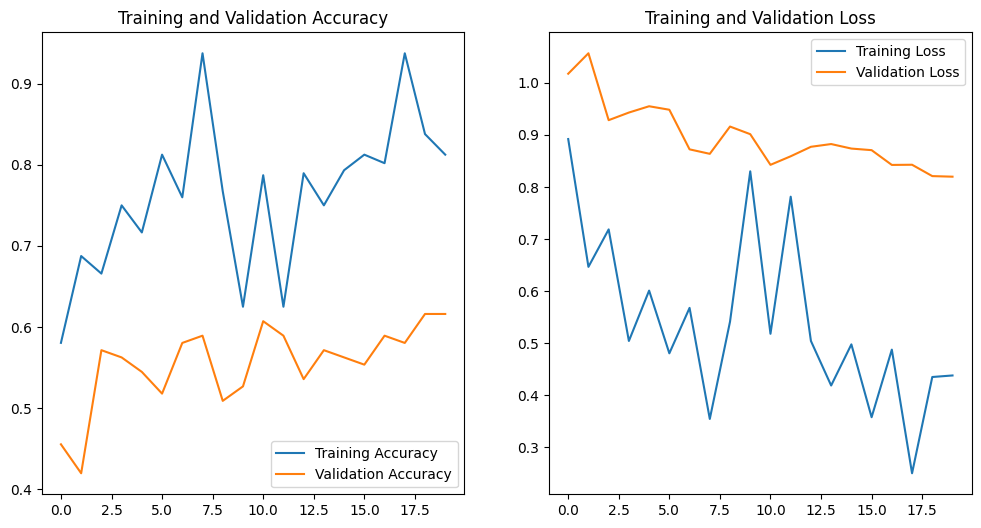

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# ===================================================================
# EVALUASI MODEL PADA DATA TEST
# ===================================================================

print("🔍 Evaluasi Model pada Data Test...")

# Load model terbaik
best_model = tf.keras.models.load_model('best_model_densenet_breast_cancer_clahe_norm.keras')

# Reset generator untuk memastikan dimulai dari awal
test_generator.reset()

# Prediksi pada data test
test_steps = int(np.ceil(test_generator.samples / test_generator.batch_size))
predictions = best_model.predict(test_generator, steps=test_steps, verbose=1)

# Dapatkan kelas prediksi dan kelas sebenarnya
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Pastikan jumlah prediksi sesuai dengan jumlah data test
predicted_classes = predicted_classes[:len(true_classes)]

print(f"\n✅ Evaluasi selesai!")
print(f"Total sampel test: {test_generator.samples}")
print(f"Total prediksi: {len(predicted_classes)}")
print(f"Total true labels: {len(true_classes)}")


🔍 Evaluasi Model pada Data Test...
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step 

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93

✅ Evaluasi selesai!
Total sampel test: 93
Total prediksi: 93
Total true labels: 93


In [ ]:
# ===================================================================
# PERHITUNGAN METRIK EVALUASI
# ===================================================================

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Hitung metrik untuk setiap kelas
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average=None)
recall = recall_score(true_classes, predicted_classes, average=None)
f1 = f1_score(true_classes, predicted_classes, average=None)

# Hitung metrik rata-rata
precision_avg = precision_score(true_classes, predicted_classes, average='weighted')
recall_avg = recall_score(true_classes, predicted_classes, average='weighted')
f1_avg = f1_score(true_classes, predicted_classes, average='weighted')

# Tampilkan hasil
print("=" * 70)
print("HASIL EVALUASI MODEL PADA DATA TEST")
print("=" * 70)
print(f"\n📊 Overall Metrics:")
print(f"  Accuracy  : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision : {precision_avg:.4f}")
print(f"  Recall    : {recall_avg:.4f}")
print(f"  F1-Score  : {f1_avg:.4f}")

print(f"\n📊 Per-Class Metrics:")
for i, class_name in enumerate(class_names):
    print(f"\n  {class_name.upper()}:")
    print(f"    Precision : {precision[i]:.4f}")
    print(f"    Recall    : {recall[i]:.4f}")
    print(f"    F1-Score  : {f1[i]:.4f}")

print("\n" + "=" * 70)


HASIL EVALUASI MODEL PADA DATA TEST

📊 Overall Metrics:
  Accuracy  : 0.7634 (76.34%)
  Precision : 0.7682
  Recall    : 0.7634
  F1-Score  : 0.7608

📊 Per-Class Metrics:

  BENIGN:
    Precision : 0.8095
    Recall    : 0.7727
    F1-Score  : 0.7907

  MALIGNANT:
    Precision : 0.7143
    Recall    : 0.8333
    F1-Score  : 0.7692

  NORMAL:
    Precision : 0.7778
    Recall    : 0.5385
    F1-Score  : 0.6364



In [ ]:
# ===================================================================
# CLASSIFICATION REPORT
# ===================================================================

print("📋 Classification Report:\n")
report = classification_report(true_classes, predicted_classes, target_names=class_names, digits=4)
print(report)

# Simpan report sebagai dictionary untuk visualisasi nanti
from sklearn.metrics import classification_report
report_dict = classification_report(true_classes, predicted_classes, target_names=class_names, output_dict=True)


📋 Classification Report:

              precision    recall  f1-score   support

      benign     0.8095    0.7727    0.7907        44
   malignant     0.7143    0.8333    0.7692        36
      normal     0.7778    0.5385    0.6364        13

    accuracy                         0.7634        93
   macro avg     0.7672    0.7148    0.7321        93
weighted avg     0.7682    0.7634    0.7608        93



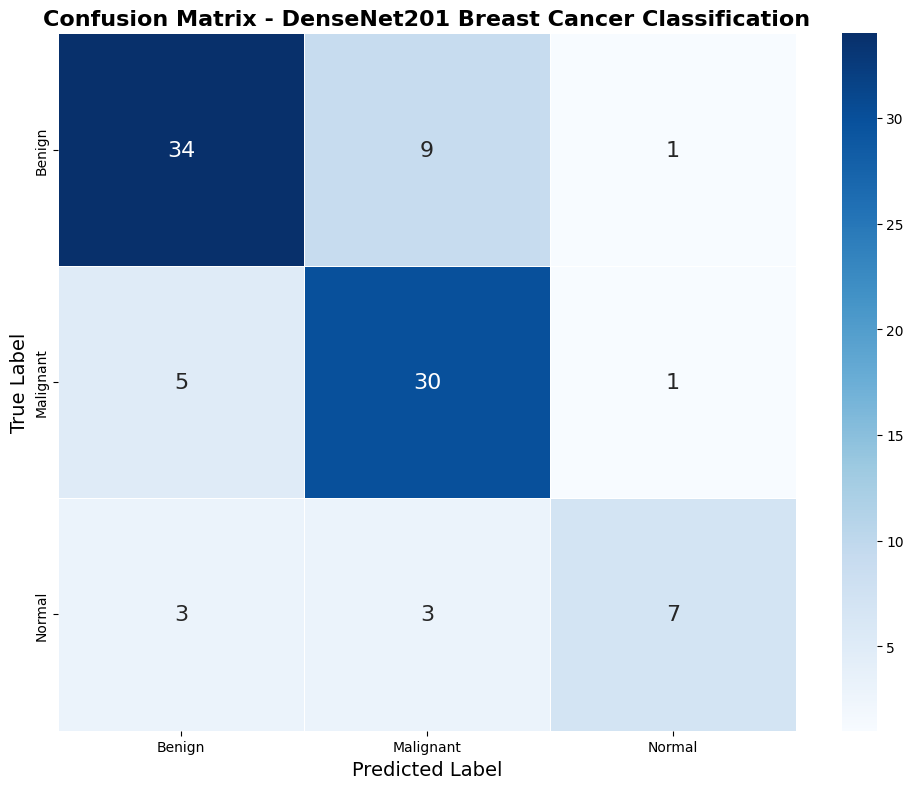

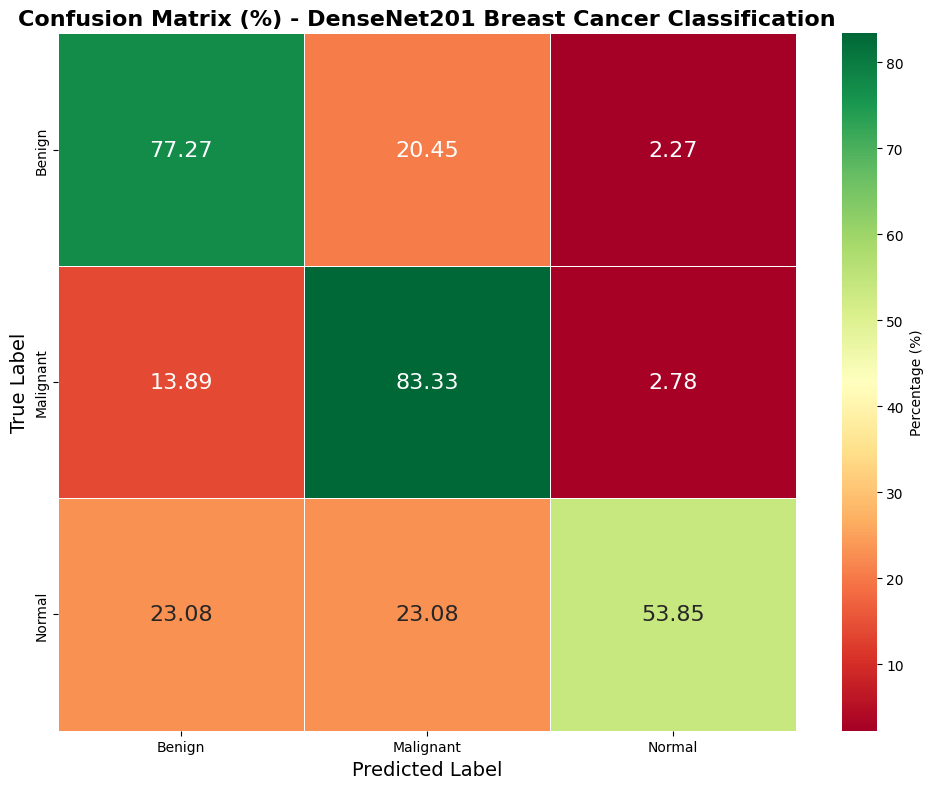

In [ ]:
# ===================================================================
# CONFUSION MATRIX VISUALIZATION
# ===================================================================

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[c.capitalize() for c in class_names], 
            yticklabels=[c.capitalize() for c in class_names],
            linewidths=0.5, annot_kws={"size": 16})

plt.title('Confusion Matrix - DenseNet201 Breast Cancer Classification', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()

# Tampilkan confusion matrix dalam bentuk persentase
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=[c.capitalize() for c in class_names], 
            yticklabels=[c.capitalize() for c in class_names],
            linewidths=0.5, annot_kws={"size": 16}, cbar_kws={'label': 'Percentage (%)'})

plt.title('Confusion Matrix (%) - DenseNet201 Breast Cancer Classification', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=14)
plt.xlabel('Predicted Label', fontsize=14)
plt.tight_layout()
plt.show()


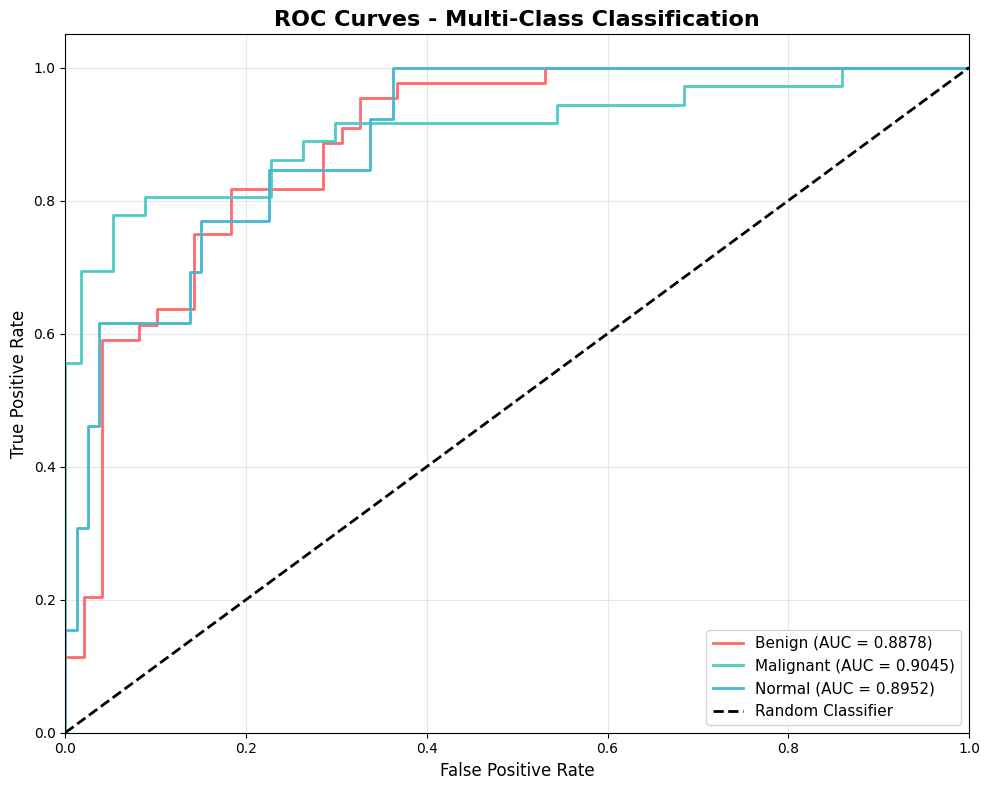

📊 AUC Scores:
  Benign: 0.8878
  Malignant: 0.9045
  Normal: 0.8952


In [ ]:
# ===================================================================
# ROC CURVE & AUC SCORE (Multi-Class)
# ===================================================================

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize labels untuk ROC multi-class
y_test_binarized = label_binarize(true_classes, classes=range(NUM_CLASSES))
y_score = predictions[:test_generator.samples]

# Compute ROC curve dan AUC untuk setiap kelas
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['#FF6B6B', '#4ECDC4', '#45B7D1'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i].capitalize()} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Multi-Class Classification', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("📊 AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"  {class_name.capitalize()}: {roc_auc[i]:.4f}")


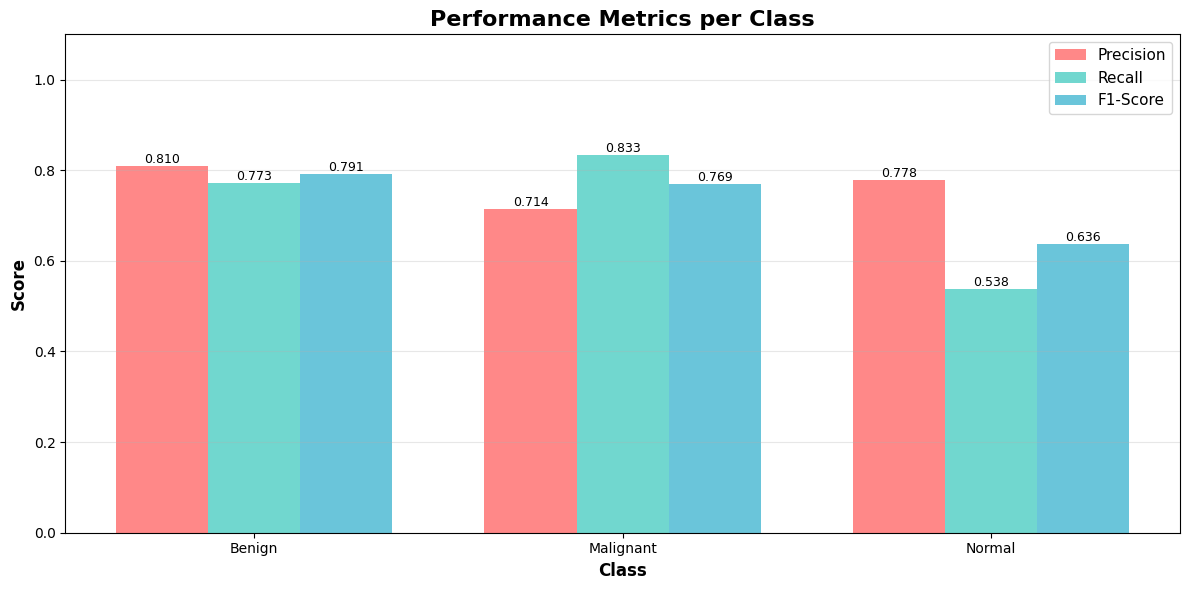

In [ ]:
# ===================================================================
# METRIK PER-CLASS VISUALIZATION (Bar Charts)
# ===================================================================

# Prepare data
metrics_data = {
    'Class': [c.capitalize() for c in class_names],
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

import pandas as pd
df_metrics = pd.DataFrame(metrics_data)

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

bars1 = ax.bar(x - width, precision, width, label='Precision', color='#FF6B6B', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', color='#4ECDC4', alpha=0.8)
bars3 = ax.bar(x + width, f1, width, label='F1-Score', color='#45B7D1', alpha=0.8)

ax.set_xlabel('Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics per Class', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([c.capitalize() for c in class_names])
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
# ===================================================================
# SUMMARY TABLE - COMPREHENSIVE RESULTS
# ===================================================================

import pandas as pd

# Create comprehensive summary table
summary_data = []
for i, class_name in enumerate(class_names):
    summary_data.append({
        'Class': class_name.capitalize(),
        'Precision': f"{precision[i]:.4f}",
        'Recall': f"{recall[i]:.4f}",
        'F1-Score': f"{f1[i]:.4f}",
        'Support': int(cm[i].sum())
    })

# Add overall metrics
summary_data.append({
    'Class': 'OVERALL (Weighted)',
    'Precision': f"{precision_avg:.4f}",
    'Recall': f"{recall_avg:.4f}",
    'F1-Score': f"{f1_avg:.4f}",
    'Support': int(cm.sum())
})

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("📊 COMPREHENSIVE EVALUATION SUMMARY")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Display as styled table
from IPython.display import display
styled_df = df_summary.style.set_properties(**{
    'text-align': 'center',
    'font-size': '12pt',
}).set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#4ECDC4'), ('color', 'white'), 
                                  ('font-weight', 'bold'), ('text-align', 'center')]},
    {'selector': 'tr:nth-of-type(odd)', 'props': [('background-color', '#f9f9f9')]},
    {'selector': 'tr:last-child', 'props': [('background-color', '#FFE66D'), ('font-weight', 'bold')]}
])

display(styled_df)



📊 COMPREHENSIVE EVALUATION SUMMARY
             Class Precision Recall F1-Score  Support
            Benign    0.8095 0.7727   0.7907       44
         Malignant    0.7143 0.8333   0.7692       36
            Normal    0.7778 0.5385   0.6364       13
OVERALL (Weighted)    0.7682 0.7634   0.7608       93


,Class,Precision,Recall,F1-Score,Support
0,Benign,0.8095,0.7727,0.7907,44
1,Malignant,0.7143,0.8333,0.7692,36
2,Normal,0.7778,0.5385,0.6364,13
3,OVERALL (Weighted),0.7682,0.7634,0.7608,93


In [ ]:
# ===================================================================
# TRAINING HISTORY ANALYSIS
# ===================================================================

# Create detailed training history table
history_df = pd.DataFrame({
    'Epoch': range(1, len(history.history['accuracy']) + 1),
    'Train Accuracy': [f"{acc:.4f}" for acc in history.history['accuracy']],
    'Val Accuracy': [f"{acc:.4f}" for acc in history.history['val_accuracy']],
    'Train Loss': [f"{loss:.4f}" for loss in history.history['loss']],
    'Val Loss': [f"{loss:.4f}" for loss in history.history['val_loss']]
})

print("\n📈 TRAINING HISTORY (First and Last 5 Epochs):")
print("="*80)
print("First 5 Epochs:")
print(history_df.head().to_string(index=False))
print("\nLast 5 Epochs:")
print(history_df.tail().to_string(index=False))
print("="*80)

# Find best epoch
best_epoch = np.argmax(history.history['val_accuracy']) + 1
best_val_acc = np.max(history.history['val_accuracy'])

print(f"\n🏆 Best Epoch: {best_epoch}")
print(f"   Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")



📈 TRAINING HISTORY (First and Last 5 Epochs):
First 5 Epochs:
 Epoch Train Accuracy Val Accuracy Train Loss Val Loss
     1         0.5804       0.4554     0.8920   1.0175
     2         0.6875       0.4196     0.6466   1.0567
     3         0.6658       0.5714     0.7185   0.9283
     4         0.7500       0.5625     0.5043   0.9429
     5         0.7166       0.5446     0.6010   0.9550

Last 5 Epochs:
 Epoch Train Accuracy Val Accuracy Train Loss Val Loss
    16         0.8125       0.5536     0.3578   0.8707
    17         0.8020       0.5893     0.4876   0.8423
    18         0.9375       0.5804     0.2501   0.8427
    19         0.8379       0.6161     0.4350   0.8209
    20         0.8125       0.6161     0.4380   0.8197

🏆 Best Epoch: 19
   Best Validation Accuracy: 0.6161 (61.61%)


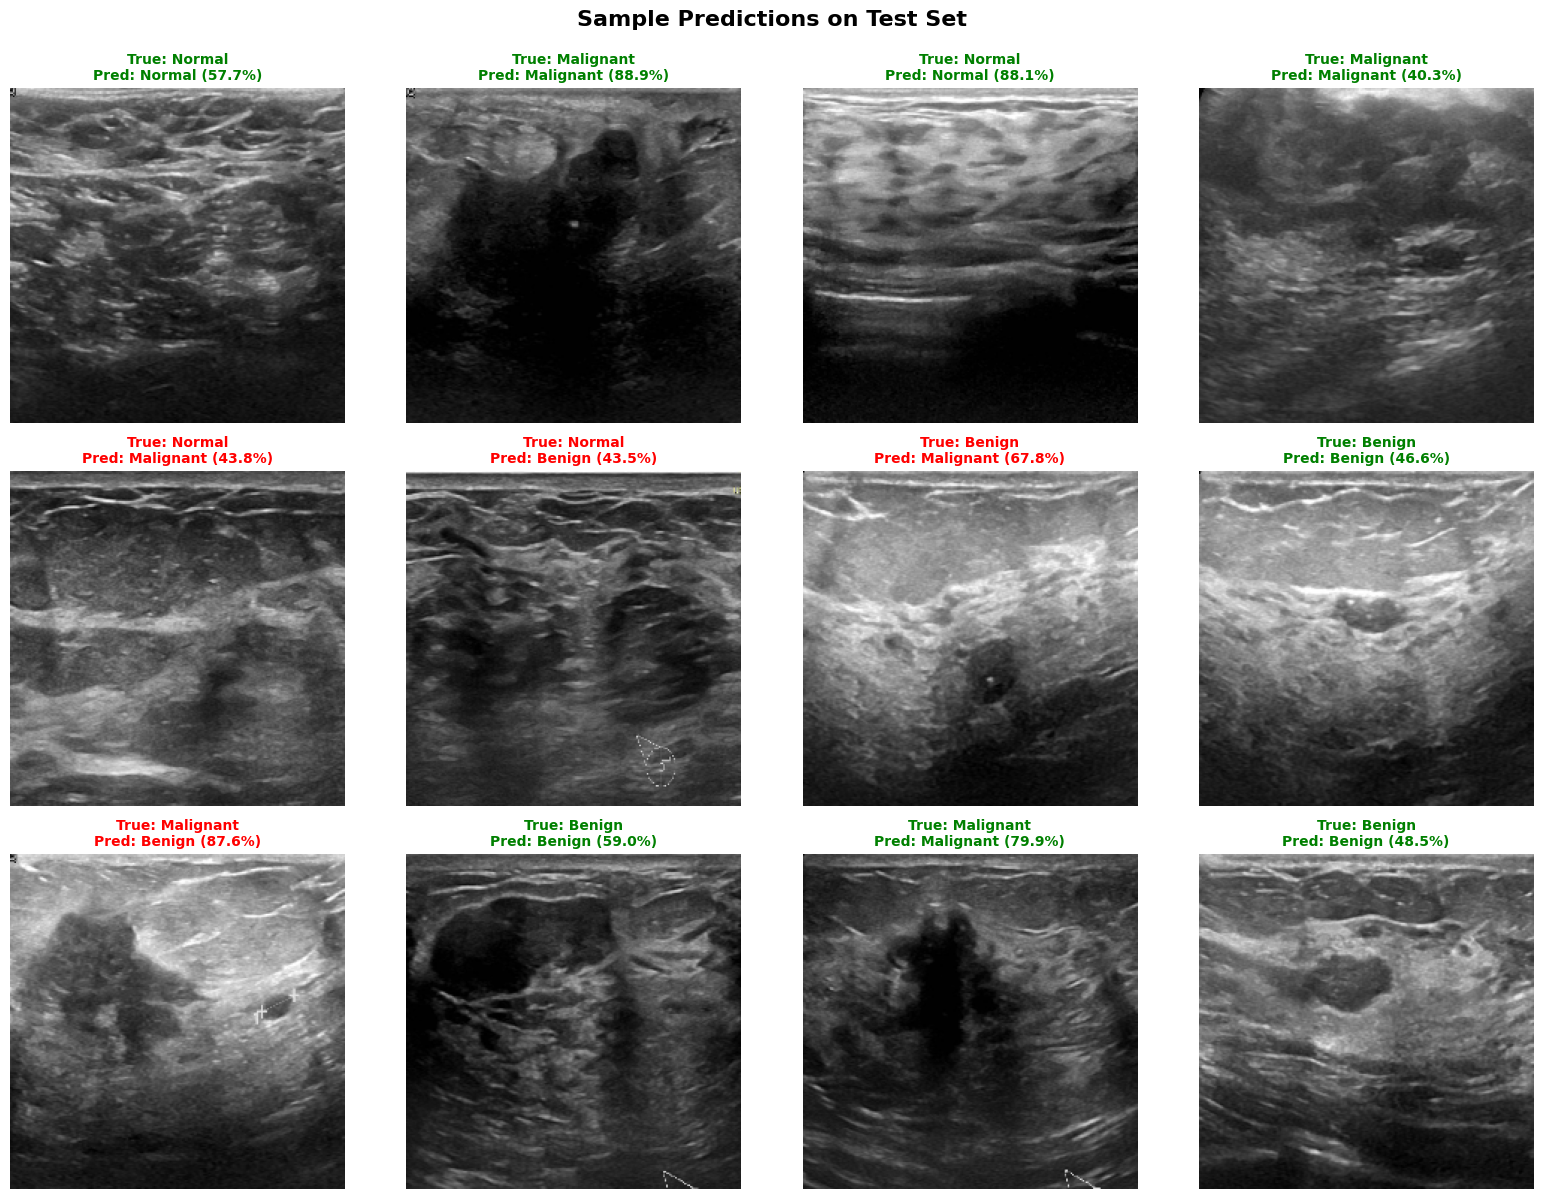

In [ ]:
# ===================================================================
# SAMPLE PREDICTIONS VISUALIZATION
# ===================================================================

import random

# Get random samples from test set
num_samples = 12
test_files = []
test_labels = []

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(TEST_DIR, class_name)
    if os.path.exists(class_dir):
        files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        # Ambil 4 sampel dari setiap kelas
        sampled = random.sample(files, min(4, len(files)))
        test_files.extend(sampled)
        test_labels.extend([class_idx] * len(sampled))

# Shuffle
combined = list(zip(test_files, test_labels))
random.shuffle(combined)
sample_files, sample_labels = zip(*combined)
sample_files = list(sample_files[:num_samples])
sample_labels = list(sample_labels[:num_samples])

# Create predictions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for idx, (img_path, true_label) in enumerate(zip(sample_files, sample_labels)):
    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Apply preprocessing
    img_processed = apply_clahe_preprocessing(img_resized)
    img_array = np.expand_dims(img_processed, axis=0)
    
    # Predict
    pred = best_model.predict(img_array, verbose=0)
    pred_class = np.argmax(pred[0])
    confidence = pred[0][pred_class]
    
    # Display
    axes[idx].imshow(img_resized)
    
    # Color: green if correct, red if wrong
    color = 'green' if pred_class == true_label else 'red'
    title = f"True: {class_names[true_label].capitalize()}\n"
    title += f"Pred: {class_names[pred_class].capitalize()} ({confidence*100:.1f}%)"
    
    axes[idx].set_title(title, color=color, fontweight='bold', fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Predictions on Test Set', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [ ]:
# ===================================================================
# FINAL SUMMARY REPORT
# ===================================================================

print("\n" + "="*80)
print("🎯 FINAL EVALUATION REPORT - DenseNet201 Breast Cancer Classification")
print("="*80)

print("\n📁 Dataset Information:")
print(f"   Training samples: {train_generator.samples}")
print(f"   Validation samples: {validation_generator.samples}")
print(f"   Test samples: {test_generator.samples}")
print(f"   Classes: {', '.join([c.capitalize() for c in class_names])}")

print("\n🏗️ Model Architecture:")
print(f"   Backbone: DenseNet201 (Pre-trained on ImageNet)")
print(f"   Custom Head: Fast Learning Network (FLN)")
print(f"   Hidden Neurons: {NEURONS_FLN}")
print(f"   Dropout Rate: {DROPOUT_RATE}")

print("\n⚙️ Training Configuration:")
print(f"   Optimizer: Adam")
print(f"   Learning Rate: {LEARNING_RATE}")
print(f"   Batch Size: {BATCH_SIZE}")
print(f"   Epochs Trained: {len(history.history['accuracy'])}")
print(f"   Best Epoch: {best_epoch}")

print("\n🔬 Preprocessing:")
print(f"   CLAHE: ✓ (Contrast Limited Adaptive Histogram Equalization)")
print(f"   Data Augmentation: ✓ (Rotation, Shift, Zoom, Flip)")

print("\n📊 Test Set Performance:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision (Weighted): {precision_avg:.4f}")
print(f"   Recall (Weighted): {recall_avg:.4f}")
print(f"   F1-Score (Weighted): {f1_avg:.4f}")

print("\n📈 Per-Class F1-Scores:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name.capitalize()}: {f1[i]:.4f}")

print("\n🎯 AUC Scores:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name.capitalize()}: {roc_auc[i]:.4f}")

print("\n" + "="*80)
print("✅ Evaluation Complete!")
print("="*80)



🎯 FINAL EVALUATION REPORT - DenseNet201 Breast Cancer Classification

📁 Dataset Information:
   Training samples: 824
   Validation samples: 113
   Test samples: 93
   Classes: Benign, Malignant, Normal

🏗️ Model Architecture:
   Backbone: DenseNet201 (Pre-trained on ImageNet)
   Custom Head: Fast Learning Network (FLN)
   Hidden Neurons: 471
   Dropout Rate: 0.44

⚙️ Training Configuration:
   Optimizer: Adam
   Learning Rate: 0.000506
   Batch Size: 16
   Epochs Trained: 20
   Best Epoch: 19

🔬 Preprocessing:
   CLAHE: ✓ (Contrast Limited Adaptive Histogram Equalization)
   Data Augmentation: ✓ (Rotation, Shift, Zoom, Flip)

📊 Test Set Performance:
   Accuracy: 0.7634 (76.34%)
   Precision (Weighted): 0.7682
   Recall (Weighted): 0.7634
   F1-Score (Weighted): 0.7608

📈 Per-Class F1-Scores:
   Benign: 0.7907
   Malignant: 0.7692
   Normal: 0.6364

🎯 AUC Scores:
   Benign: 0.8878
   Malignant: 0.9045
   Normal: 0.8952

✅ Evaluation Complete!


In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block32_concat", pred_index=None):
    # 1. Buat model yang memetakan input ke aktivasi layer konvolusi terakhir dan output
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # 2. Rekam gradien
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 3. Hitung gradien output terhadap feature map
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    # 4. Global Average Pooling pada gradien
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 5. Kalikan feature map dengan bobot gradien
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # 6. Normalisasi Heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model):
    # Load Image manual
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    
    # Preprocess
    img_processed = apply_clahe_preprocessing(original_img)
    img_array = np.expand_dims(img_processed, axis=0)

    # Hapus softmax di layer terakhir agar gradien lebih tajam (opsional tapi disarankan)
    model.layers[-1].activation = None

    # Generate Heatmap
    # Layer 'conv5_block32_concat' adalah layer output terakhir DenseNet201
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block32_concat")

    # Tampilkan
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Citra Asli")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(original_img)
    plt.imshow(heatmap, cmap='jet', alpha=0.5) # Overlay
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()

# --- CONTOH PENGGUNAAN ---
# Ganti dengan path file gambar USG asli yang ingin dites
# display_gradcam("dataset/malignant/malignant (10).png", best_model)